# Deep Neural Network Visualization - Create Models
<hr>

# 0. Setup Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import keras

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.models import model_from_json

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
import numpy as np
import scipy
import re

In [5]:
from PIL import Image

In [6]:
import codecs
import json 

### Set Current Path

In [7]:
current_path = os.getcwd()
os.chdir(current_path)

# 1. Setup Training / Test Data

### A. Load MNIST Dataset

In [8]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### X data (features)

In [9]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


### Y data (labels)

In [10]:
num_classes = 10

# Convert y_train and y_test to categorical datatypes
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# 2. Construct Model

### i. Setup Create New Model Function

In [11]:
def create_new_model(input_dim=784, hidden_dim=512, dropout_rate=0.2, summary=True, dropout=True):
    
    # Initialize model
    model = Sequential()
    
    # Layer 1 - INPUT
    model.add(Dense(hidden_dim, activation='relu', input_shape=(input_dim,)))
    if dropout:
        model.add(Dropout(dropout_rate))
    
    # Layer 2 - HIDDEN
    model.add(Dense(hidden_dim, activation='relu'))
    if dropout:
        model.add(Dropout(dropout_rate))
    
    # Layer 3 - OUTPUT
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    
    if summary: print(model.summary())
    
    return model

## A. Generate Models

In [12]:
new_model_num = 3
hidden_dims = [512, 512, 512]
dropouts = [0.2, 0.6, 0.9]
models = {}

for model_num in range(1, new_model_num+1):
    new_model_name = "model_{}".format(model_num)
    hidden_dim = hidden_dims[model_num-1]
    dropout = dropouts[model_num-1]
    new_model = create_new_model(hidden_dim=hidden_dim, dropout_rate=dropout)
    models[new_model_name] = {"model_t0" : new_model}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706.0
Trainable params: 669,706.0
Non-trainable params: 0.0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Para

# 3. Train Models

### i. Setup Train Parameters

In [13]:
batch_size = 128

## A. Train

In [14]:
def score_model(model):
    test_score = model.evaluate(x_test, y_test, verbose=0)
    train_score = model.evaluate(x_train, y_train, verbose=0)
    model_score = {"test loss" : test_score[0], 
                        "test accuracy" : test_score[1],
                        "train accuracy" : train_score[1]
                  }
    
    return model_score

In [15]:
time_steps = 15
num_training_samples = 10000
num_test_samples = 1000

    
for model_name, items in models.items():
    
    # Set current model
    model = items["model_t0"]
    
    # Get layer 1 weights from initiale model
    layer_1_initial_weights = np.array(model.layers[0].get_weights()[0]).flatten()
        
    # Declare time series list to store layer 1 weights at each epoch step
    model_weights_time_series = [layer_1_initial_weights.tolist()]
    
    # Get initial model scores
    initial_model_score = score_model(model)
    model_scores_time_series = [initial_model_score]
    
    # Increment by 1 epoch each loop, store weight from layer 1 of each iteration of the model
    for time_step in range(1, time_steps+1):
        
        # Randomly draw *num_training_samples* from x_test, y_test
        random_training_indices = [np.random.randint(0, 60000) for _ in range(num_training_samples)]
        random_test_indices = [np.random.randint(0, 10000) for _ in range(num_test_samples)]
        
        # Set stubbed training / testing data
        x_train_stubb = x_train[random_training_indices]
        y_train_stubb = y_train[random_training_indices]
        x_test_stubb = x_test[random_test_indices]
        y_test_stubb = y_test[random_test_indices]
        
        # Set verbosity
        verbosity = 1 if time_steps < 10 else 0
        
        # Fit the model
        model.fit(x_train_stubb, y_train_stubb, epochs=1, batch_size=batch_size, validation_data=(x_test_stubb, y_test_stubb), verbose=verbosity)
        
        # Get the layer 1 weights
        layer_1_weights = np.array(model.layers[0].get_weights()[0]).flatten()
       
        # Store layer 1 weights
        model_weights_time_series.append(layer_1_weights.tolist())
        
        
        # Get model score and store it
        model_score = score_model(model)
        model_scores_time_series.append(model_score)
    
    # Store model weights time sequence
    models[model_name]["epochs"] = model_weights_time_series
    
    # Store final model
    models[model_name]["model_tf"] = model
    
    # Store model scores at each epoch
    models[model_name]["scores"] = model_scores_time_series


## Plot the weight distributions

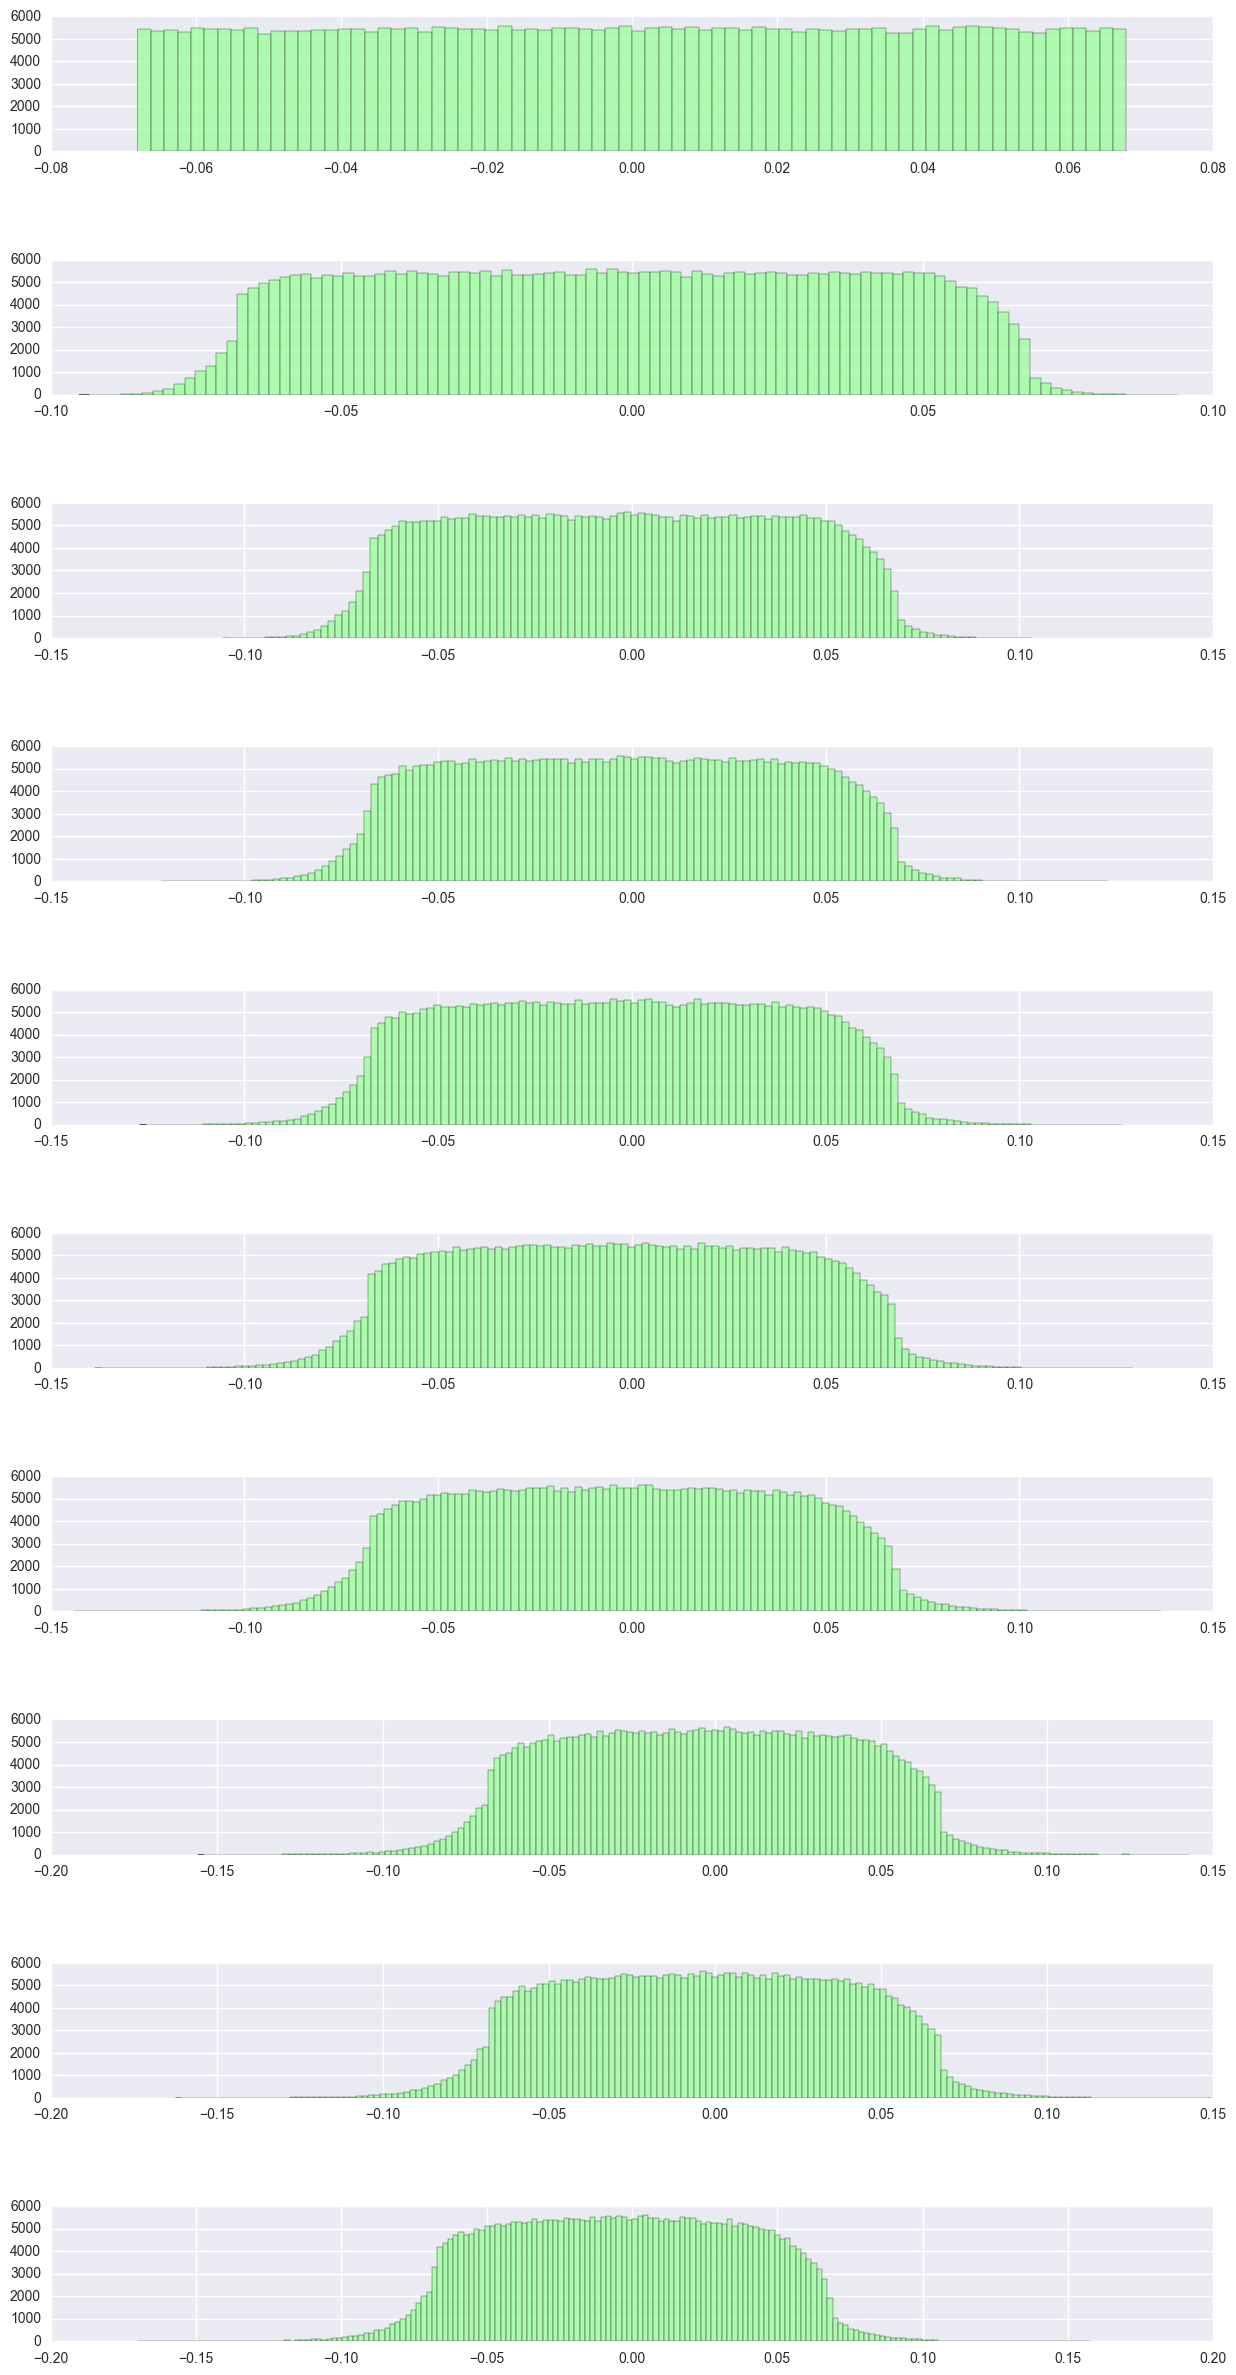

In [16]:
plot_number = 10

# Setup figure
fig = plt.figure()

for model_name, items in models.items():
    for time_step, layer in enumerate(items["epochs"]):
        
        if time_step >= plot_number:
            break
        
        # Setup the axis
        ax = fig.add_subplot(plot_number, 1, time_step+1)
        
        # Plot the layer weights
        sns.distplot(layer, bins='auto', kde=False, rug=False, ax=ax, color="#99ff99", hist_kws=dict(alpha=0.75))
        
    # Figure attributes
    fig.subplots_adjust(hspace=0.8)
    fig.set_figheight(30)
    fig.set_figwidth(15)
    
    # Show the plot
    plt.show()  

# 4. Score Models

In [17]:
for model_name, items in models.items():
    print(model_name)
    model = items["model_tf"]
    test_score = model.evaluate(x_test, y_test, verbose=0)
    train_score = model.evaluate(x_train, y_train, verbose=0)
    models[model_name]["score_tf"] = {"test loss" : test_score[0], 
                                   "test accuracy" : test_score[1],
                                   "train accuracy" : train_score[1]}
    
    print('Test loss: {}'.format(test_score[0]))
    print('Train accuracy: {}'.format(train_score[1]))
    print('Test accuracy: {}'.format(test_score[1]))
    print("\n")

model_3
Test loss: 0.35288393278717994
Train accuracy: 0.9167333333333333
Test accuracy: 0.9158


model_2
Test loss: 0.11954072921889601
Train accuracy: 0.9730666666666666
Test accuracy: 0.9673


model_1
Test loss: 0.10083307379449252
Train accuracy: 0.9814666666666667
Test accuracy: 0.9716




## Extract Weight Matrices from Model

#### weights to json function

In [18]:
def weights_to_json(data, file_name):
    # Set file path
    file_path = "json_files/{}.json".format(file_name)
    
    # Dump json data
    json.dump(data, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)


### Format and write data

In [19]:
for model_name, items in models.items():
    
    # Define the edata to write
    write_data = { "epochs" : items["epochs"],
                   "scores" : items["scores"] 
                 }
    
    # write to json
    weights_to_json(write_data, model_name)

### Write list of models in csv for D3 to read

In [20]:
with open("json_files/model_list.csv", "w") as outfile:
    outfile.write("Model Name,Model Filename\n")
    for model_key in models.keys():
        outfile.write(model_key)
        outfile.write(",")
        outfile.write(model_key+".json")
        outfile.write("\n")

## Save Trained Model and Weights to file

In [21]:
for model_name, items in models.items():

    # Set model
    model = items["model_tf"]

    # serialize model to JSON
    model_json = model.to_json()

    # Write model to file
    outfile_name = "models/{}.json".format(model_name)
    with open(outfile_name, "w") as json_file:
        json_file.write(model_json)

    # Serialize weights to HDF5 and save
    model.save_weights("models/{}_weights.h5".format(model_name))

    print("Saved {} to disk.".format(model_name))

Saved model_3 to disk.
Saved model_2 to disk.
Saved model_1 to disk.


# Appendix A: References

## Keras
- https://keras.io/getting-started/sequential-model-guide/
- https://keras.io/models/sequential/#sequential-model-methods

## Numpy and Images
- http://scikit-image.org/docs/dev/user_guide/numpy_images.html
- astropy, but useful: http://prancer.physics.louisville.edu/astrowiki/index.php/Image_processing_with_Python_and_SciPy
- https://www.safaribooksonline.com/library/view/programming-computer-vision/9781449341916/ch01.html

## Resizing images for NN processing
- https://datascience.stackexchange.com/questions/5224/how-to-prepare-images-for-neural-network

## Database
- MongoDB: https://realpython.com/blog/python/introduction-to-mongodb-and-python/

## Saving Net One Step at a Time
- https://github.com/fchollet/keras/issues/85

## Dict to JSON
- http://robotfantastic.org/serializing-python-data-to-json-some-edge-cases.html

## Batch Size Explained Well
- https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network

## Datasets

#### MIT Places
The compressed file of resized 256*256 images, containing train set and validation set of Places 205.
http://data.csail.mit.edu/places/places205/imagesPlaces205_resize.tar.gz